In [1]:
using Plots
using LinearAlgebra
using Parameters
using StaticArrays
using Roots

In [57]:
module My

using Parameters 

@with_kw struct PhysicalParam{T} @deftype Float64 
    ħc = 197.
    mc² = 938.
    M = ħc^2/2mc²
    
    Z::Int64 = 8
    N::Int64 = 8
    A::Int64 = Z + N
    
    # parameters for initial density
    r₀ = 1.2
    R = r₀*A^(1/3)
    a = 0.67
    ρ₀ = 3/(4π*r₀^3)
    
    # skyrme parameters
    t₀ = -1800
    x₀ = 0.0
    t₃ = 12871
    x₃ = 0.0
    α = 1/3
    
    # radial grids
    Nr::Int64 = 100
    Δr = 0.1
    rs::T = range(0, Nr*Δr, length=Nr+1)
    
    ir_matching::Int64 = floor(Int, R/Δr) + 1
    
    # energy
    Emin = -70.0
    Emax = 0.0
    ΔE = 0.1
    Es::T = range(Emin, Emax, step=ΔE)
    
    # maximal value of angular momentum
    lmax::Int64 = 5
    nstates_max::Int64 = 1000
    
    # buffer for integrating HF eq.
    ys_p::Vector{Float64} = similar(rs)
    ys_m::Vector{Float64} = similar(rs)
    
    Gs::Vector{Float64} = similar(rs)
    As::Vector{Float64} = similar(rs)
    
    # derivative
    dψ::Vector{Float64} = similar(rs)
end

@with_kw struct QuantumNumbers @deftype Int64
    l = 0
    j = 1
    q = 1 # q=1 for neutron, q=2 for proton
end

@with_kw struct Densities
    ρq::Matrix{Float64}; @assert size(ρq, 2) === 2
    τq::Matrix{Float64}; @assert size(τq, 2) === 2
    ρtot::Vector{Float64}
    τtot::Vector{Float64}
end

@with_kw struct HFstates
    nstates_max::Int64
    spEs::Vector{Float64}; @assert length(spEs) === nstates_max
    qnums::Vector{QuantumNumbers} ; @assert length(qnums) === nstates_max
    wfs::Matrix{Float64}; @assert size(wfs, 2) === nstates_max
    occ::Vector{Float64}; @assert length(occ) === nstates_max
end

end # module My

Main.My

In [58]:
function make_HFstates(param)
    @unpack Nr, nstates_max = param 
    
    spEs  = zeros(Float64, nstates_max)
    spEs .= 1e10
    
    qnums = Vector{My.QuantumNumbers}(undef, nstates_max)
    wfs = zeros(Float64, Nr+1, nstates_max)
    occ = zeros(Float64, nstates_max)
    
    My.HFstates(nstates_max, spEs, qnums, wfs, occ)
end

make_HFstates (generic function with 1 method)

In [59]:
param = My.PhysicalParam(N=10)

Main.My.PhysicalParam{StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}}
  ħc: Float64 197.0
  mc²: Float64 938.0
  M: Float64 20.687100213219615
  Z: Int64 8
  N: Int64 10
  A: Int64 18
  r₀: Float64 1.2
  R: Float64 3.1448896730506757
  a: Float64 0.67
  ρ₀: Float64 0.13815533254504805
  t₀: Float64 -1800.0
  x₀: Float64 0.0
  t₃: Float64 12871.0
  x₃: Float64 0.0
  α: Float64 0.3333333333333333
  Nr: Int64 100
  Δr: Float64 0.1
  rs: StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}
  ir_matching: Int64 32
  Emin: Float64 -70.0
  Emax: Float64 0.0
  ΔE: Float64 0.1
  Es: StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}
  lmax: Int64 5
  nstates_max: Int64 1000
  ys_p: Array{Float64}((101,)) [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
  ys_m: Array{Float64}((101,)) [NaN, 62009.60524302712, 15463.374859957106,

In [5]:
function initial_density(param)
    @unpack A, N, Z, r₀, R, a, ρ₀, rs, Nr = param
    
    ρq = zeros(Float64, Nr+1, 2)
    τq = zeros(Float64, Nr+1, 2)
    ρtot = zeros(Float64, Nr+1)
    τtot = zeros(Float64, Nr+1)
    
    @. ρq[:,1] = (ρ₀*N/A)/(1 + exp((rs - R)/a))
    @. ρq[:,2] = (ρ₀*Z/A)/(1 + exp((rs - R)/a))
    @views @. ρtot = ρq[:,1] + ρq[:,2]
    
    return My.Densities(ρq, τq, ρtot, τtot)
end

function test_initial_density(param)
    @unpack rs = param 
    @time dens = initial_density(param)
    p = plot()
    plot!(rs, dens.ρq[:,1]; label="ρ_n")
    plot!(rs, dens.ρq[:,2]; label="ρ_p")
    plot!(rs, dens.ρtot; label="ρ_tot")
end

test_initial_density (generic function with 1 method)

  0.000006 seconds (4 allocations: 10.156 KiB)


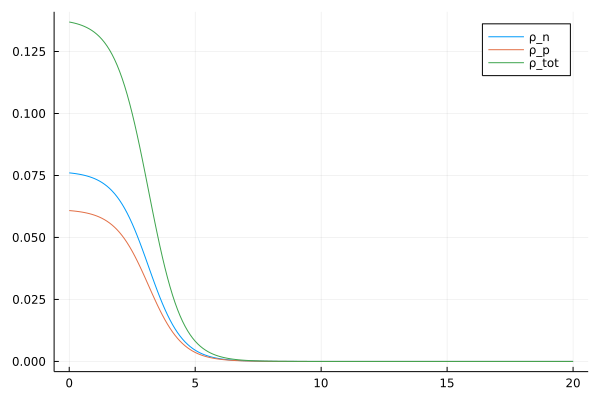

In [6]:
test_initial_density(param)

In [7]:
function calc_potential!(Vs, param, dens, qnum)
    @unpack M, t₀, x₀, t₃, x₃, α, rs = param 
    @unpack ρq, ρtot = dens
    @unpack l, j, q = qnum
    
    @views begin
        # t₀ term
        @. Vs  = t₀*((1+0.5x₀)*ρtot - (x₀+0.5)*ρq[:,q])
        
        # t₃ term
        @. Vs +=  1/12*t₃*(1+0.5x₃)*(α+2)*ρtot^(α+1)
        @. Vs += -1/12*t₃*(x₃+0.5)*α*(ρtot^(α-1))*
                    (ρq[:,1]*ρq[:,1]+ρq[:,2]*ρq[:,2])
        @. Vs += -1/12*t₃*(x₃+0.5)*2*(ρtot^α)*ρq[:,q]
        
        # centrifugal potential
        @. Vs += M*l*(l+1)/rs^2
    end
end

function test_calc_potential!(param; l=0)
    @unpack rs = param
    
    dens = initial_density(param)
    
    Vs = similar(rs)
    p = plot(; ylim=(-60, 10))
    
    qnum = My.QuantumNumbers(l=l, q=1)
    @time calc_potential!(Vs, param, dens, qnum)
    plot!(rs, Vs; label="V_n")
    
    qnum = My.QuantumNumbers(l=l, q=2)
    @time calc_potential!(Vs, param, dens, qnum)
    plot!(rs, Vs; label="V_p")
end

test_calc_potential! (generic function with 1 method)

  0.000009 seconds
  0.000006 seconds


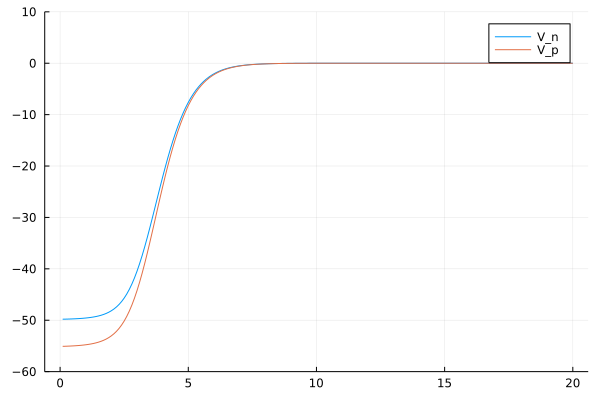

In [8]:
test_calc_potential!(param; l=0)

In [9]:
function normalize!(ys, rs)
    Δr = rs[2]-rs[1]
    norm = 0.0
    for ir in 1:length(rs)
        norm += ys[ir]^2
    end
    norm *= Δr
    norm = sqrt(norm)
    @. ys /= norm
    return 
end

function integrate_HFeq!(param, Vs, E, qnum)
    @unpack M, Nr, Δr, rs, ir_matching, 
        ys_p, ys_m, Gs, As = param
    
    @unpack l, j, q = qnum
    
    @. As = 1 - (Δr*Δr/12)*(Vs-E)/M
    
    # outward integration
    fill!(ys_p, 0)
    ys_p[1] = 0.0
    ys_p[2] = Δr^(l+1)
    
    if l !== 1
        Gs[1] = 0.0
    else
        Gs[1] = - Δr*Δr/6
    end
    Gs[2] = As[2]*ys_p[2]
    
    for ir in 3:ir_matching+1
        Gs[ir] = 12ys_p[ir-1] - 10Gs[ir-1] - Gs[ir-2]
        ys_p[ir] = As[ir]\Gs[ir]
    end
    
    normalize!(ys_p, rs)
    
    # inward integration 
    fill!(ys_m, 0)
    ys_m[Nr+1] = 0.0
    ys_m[Nr  ] = Δr
    
    Gs[Nr+1] = 0.0
    Gs[Nr  ] = As[Nr]*ys_m[Nr]
    
    for ir in Nr-1: -1: ir_matching-1
        Gs[ir] = 12ys_m[ir+1] - 10Gs[ir+1] - Gs[ir+2]
        ys_m[ir] = As[ir]\Gs[ir]
    end
    
    normalize!(ys_m, rs)
    
    return
end

function test_integrate_HFeq!(param; E=-40.0, l=0, q=1)
    @unpack rs, Nr, Δr, ys_p, ys_m = param 
    
    qnum = My.QuantumNumbers(l=l, q=q)
    
    dens = initial_density(param)
    
    Vs = similar(rs)
    calc_potential!(Vs, param, dens, qnum)
    
    @time integrate_HFeq!(param, Vs, E, qnum)
    
    p = plot()
    plot!(rs, ys_p; label="ys_p")
    plot!(rs, ys_m; label="ys_m")
end

test_integrate_HFeq! (generic function with 1 method)

  0.000004 seconds


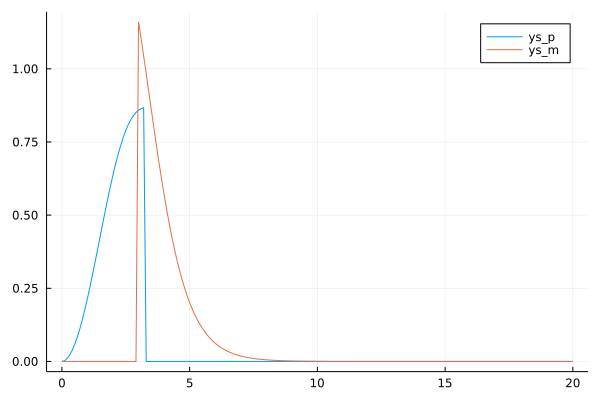

In [10]:
test_integrate_HFeq!(param; E=-30, l=1)

In [11]:
function calc_matching_condition(param)
    @unpack Δr, ir_matching, ys_p, ys_m = param
    
    ir = ir_matching 
    
    a = ys_p[ir]
    b = ys_m[ir]
    c = (ys_p[ir+1] - ys_p[ir-1])/2Δr
    d = (ys_m[ir+1] - ys_m[ir-1])/2Δr
    
    return a*d - b*c
end

calc_matching_condition (generic function with 1 method)

In [12]:
function test_calc_matching_condition(param; l=0, q=1)
    @unpack Nr, rs, Es, Δr, ys_p, ys_m = param 
    
    fs = similar(Es)
    
    qnum = My.QuantumNumbers(l=l, q=q)
    
    dens = initial_density(param)
    
    Vs = similar(rs)
    calc_potential!(Vs, param, dens, qnum)
    
    for iE in 1:length(Es)
        integrate_HFeq!(param, Vs, Es[iE], qnum)
        fs[iE] = calc_matching_condition(param)
    end
    
    fs
end

test_calc_matching_condition (generic function with 1 method)

  0.002561 seconds (6 allocations: 17.547 KiB)


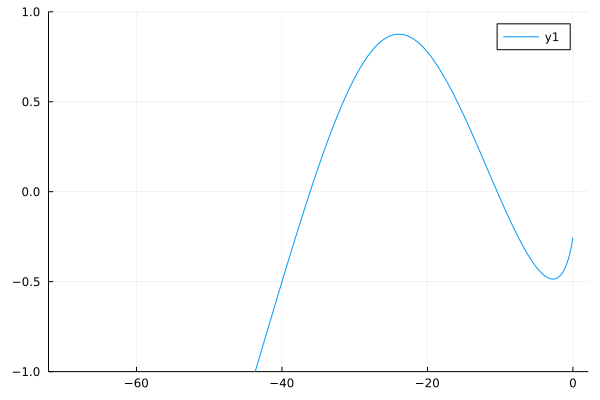

In [14]:
@time fs = test_calc_matching_condition(param; l=0)
plot(param.Es, fs; ylim=(-1,1))

In [15]:
function construct_eigenfunction!(ys, param, Vs, E, qnum)
    @unpack Nr, Δr, rs, ir_matching, ys_p, ys_m = param 
    
    integrate_HFeq!(param, Vs, E, qnum)
    
    ratio = ys_p[ir_matching]/ys_m[ir_matching]
    @. ys_m *= ratio 
    
    for ir in 1:ir_matching
        ys[ir] = ys_p[ir]
    end
    for ir in ir_matching+1:Nr+1
        ys[ir] = ys_m[ir]
    end
    
    normalize!(ys, rs)
    
    return
end

function calc_states!(states, Vs, param, dens)
    @unpack rs, Es, lmax = param 
    @unpack spEs, qnums, wfs = states
    
    fill!(spEs, 1e10)
    
    istate = 0
    for l in 0:lmax, q in 1:2
        qnum = My.QuantumNumbers(l=l, q=q)
        calc_potential!(Vs, param, dens, qnum)
        
        function f(E)
            integrate_HFeq!(param, Vs, E, qnum)
            calc_matching_condition(param)
        end
        
        for i in 1:length(Es)-1
            f₁ = f(Es[i])
            f₂ = f(Es[i+1])

            @views if f₁*f₂ < 0
                E = find_zero(f, (Es[i], Es[i+1]), Bisection())
                istate += 1
                spEs[istate] = E
                qnums[istate] = qnum
                construct_eigenfunction!(wfs[:, istate], param, Vs, E, qnum)
            end
        end
    end
end

function sort_states!(states)
    @unpack spEs, qnums, wfs = states
    p = sortperm(spEs)
    wfs[:] = wfs[:,p]
    spEs[:] = spEs[p]
    qnums[:] = qnums[p]
    return 
end

function calc_occ!(states, param)
    @unpack A, Z, N = param
    @unpack nstates_max, spEs, qnums, occ = states
    
    fill!(occ, 0)
    
    n_neutron = 0
    n_proton  = 0
    
    for i in 1:nstates_max
        if spEs[i] == 1e10
            break
        end
        
        @unpack l, q = qnums[i]
        
        if q === 1 # neutron
            if n_neutron + 2(2l+1) ≤ N
                occ[i] = 1
                n_neutron += 2(2l+1)
            elseif n_neutron < N
                occ[i] = (N - n_neutron)/2(2l+1)
                n_neutron = N
            end
        end
        
        if q === 2 # proton
            if n_proton + 2(2l+1) ≤ Z
                occ[i] = 1
                n_proton += 2(2l+1)
            elseif n_proton < Z
                occ[i] = (Z - n_proton)/2(2l+1)
                n_proton = Z
            end
        end
    end
    
    @assert n_neutron === N
    @assert n_proton  === Z
    
    return 
end

function show_states(states)
    @unpack nstates_max, spEs, qnums, occ = states
    println("")
    for i in 1:nstates_max
        if spEs[i] == 1e10
            break
        end
        println("i = $i: ")
        @show spEs[i] qnums[i] occ[i]
        println("")
    end
end

show_states (generic function with 1 method)

In [16]:
function test_calc_states!(param)
    @unpack Nr, rs = param 
    
    dens = initial_density(param)
    Vs = similar(rs)
    states = make_HFstates(param)
    
    @time calc_states!(states, Vs, param, dens)
    @time sort_states!(states)
    @time calc_occ!(states, param)
    
    show_states(states)
end

test_calc_states! (generic function with 1 method)

In [22]:
param = My.PhysicalParam(N=10,Z=8, Nr=200)
test_calc_states!(param)

  0.074615 seconds (154 allocations: 31.797 KiB)
  0.000419 seconds (7 allocations: 1.572 MiB)
  0.000000 seconds

i = 1: 
spEs[i] = -40.65423553802491
qnums[i] = Main.My.QuantumNumbers
  l: Int64 0
  j: Int64 1
  q: Int64 2

occ[i] = 1.0

i = 2: 
spEs[i] = -36.12918358830279
qnums[i] = Main.My.QuantumNumbers
  l: Int64 0
  j: Int64 1
  q: Int64 1

occ[i] = 1.0

i = 3: 
spEs[i] = -28.42813213103926
qnums[i] = Main.My.QuantumNumbers
  l: Int64 1
  j: Int64 1
  q: Int64 2

occ[i] = 1.0

i = 4: 
spEs[i] = -24.47679670474214
qnums[i] = Main.My.QuantumNumbers
  l: Int64 1
  j: Int64 1
  q: Int64 1

occ[i] = 1.0

i = 5: 
spEs[i] = -15.168231618751541
qnums[i] = Main.My.QuantumNumbers
  l: Int64 2
  j: Int64 1
  q: Int64 2

occ[i] = 0.0

i = 6: 
spEs[i] = -13.455991420881402
qnums[i] = Main.My.QuantumNumbers
  l: Int64 0
  j: Int64 1
  q: Int64 2

occ[i] = 0.0

i = 7: 
spEs[i] = -11.897850493560043
qnums[i] = Main.My.QuantumNumbers
  l: Int64 2
  j: Int64 1
  q: Int64 1

occ[i] = 0.2

i = 8: 

In [23]:
function first_deriv!(dψ, rs, ψ)
    Nr = length(rs)
    Δr = rs[2] - rs[1]
    
    dψ[1] = ψ[2]/2Δr
    for ir in 2:Nr-1
        dψ[ir] = (ψ[ir+1] - ψ[ir-1])/2Δr
    end
    dψ[Nr] = -ψ[Nr-1]/2Δr
    
    return 
end

function calc_density!(dens, param, states)
    @unpack rs, dψ = param
    @unpack nstates_max, spEs, qnums, wfs, occ = states
    @unpack ρq, τq, ρtot, τtot = dens
    
    fill!(ρq, 0)
    fill!(τq, 0)
    @views for i in 1:nstates_max
        if spEs[i] == 1e10
            break
        end
        @unpack l, q = qnums[i]
        
        ψ = wfs[:,i]
        first_deriv!(dψ, rs, ψ)
        
        @. ρq[:,q] += occ[i] * 2(2l+1)/4π * (ψ/rs)^2
        @. τq[:,q] += occ[i] * 2(2l+1)/4π * (dψ/rs - ψ/(rs*rs))*(dψ/rs - ψ/(rs*rs))
        @. τq[:,q] += occ[i] * 2(2l+1)/4π * l*(l+1)*(ψ/rs^2)^2
    end
    
    ρq[1,:] .= 0.0
    τq[1,:] .= 0.0
    
    @views @. ρtot = ρq[:,1] + ρq[:,2]
    @views @. τtot = τq[:,1] + τq[:,2]
    
    return
end

function test_calc_density(param)
    @unpack Nr, rs = param 
    
    p = plot()
    
    dens = initial_density(param)
    plot!(p, rs, dens.ρq[:,1]; label="ρn₀")
    plot!(p, rs, dens.ρq[:,2]; label="ρp₀")
    Vs = similar(rs)
    states = make_HFstates(param)
    
    calc_states!(states, Vs, param, dens)
    sort_states!(states)
    calc_occ!(states, param)
    
    @time calc_density!(dens, param, states)
    
    plot!(p, rs, dens.ρq[:,1]; label="ρn")
    plot!(p, rs, dens.τq[:,1]; label="τn")
    plot!(p, rs, dens.ρq[:,2]; label="ρp")
    plot!(p, rs, dens.τq[:,2]; label="τp")
    display(p)
    
end

test_calc_density (generic function with 1 method)

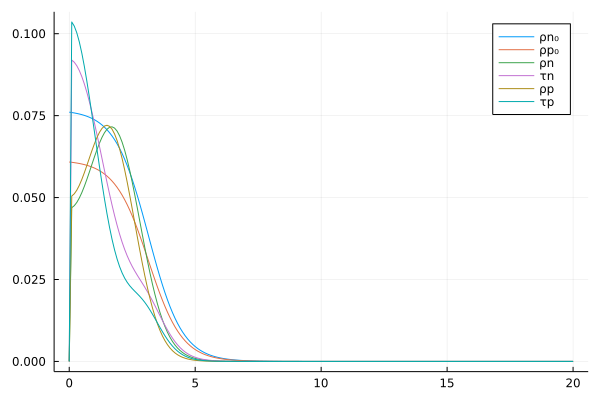

  0.000030 seconds


In [24]:
test_calc_density(param)

In [52]:
function calc_total_energy(param, dens)
    @unpack M, t₀, x₀, t₃, x₃, α, Δr, Nr, rs = param 
    @unpack ρq, τq, ρtot, τtot = dens
    
    ε = zeros(Float64, Nr+1)
    @views begin
        @. ε += M*τtot

        @. ε += +0.5t₀*(1+0.5x₀)*ρtot*ρtot
        @. ε += -0.5t₀*(x₀+0.5)*(ρq[:,1]*ρq[:,1]+ρq[:,2]*ρq[:,2])
        
        @. ε += +1/12*t₃*(1+0.5x₃)*ρtot^(α+2)
        @. ε += -1/12*t₃*(x₃+0.5)*ρtot^α*
                    (ρq[:,1]*ρq[:,1]+ρq[:,2]*ρq[:,2])
    end
    
    return sum((@. 4π*rs^2 * ε)) * Δr
end

function calc_total_energy2(param, dens, states)
    @unpack M, t₀, x₀, t₃, x₃, α, Δr, Nr, rs = param 
    @unpack ρq, τq, ρtot, τtot = dens
    @unpack nstates_max, spEs, qnums, occ = states
    
    ε = zeros(Float64, Nr+1)
    @views begin
        @. ε += 0.5M*τtot
        
        @. ε += -α/24*t₃*(1+0.5x₃)*ρtot^(α+2)
        @. ε += +α/24*t₃*(x₃+0.5)*ρtot^α*
                    (ρq[:,1]*ρq[:,1]+ρq[:,2]*ρq[:,2])
    end
    
    E = sum((@. 4π*rs^2 * ε)) * Δr
    
    for i in 1:nstates_max
        if spEs[i] == 1e10
            break
        end
        @unpack l = qnums[i]
        
        E += 0.5*2(2l+1)*occ[i]*spEs[i]
    end
    
    return E
end


function HF_calc(param; iter_max=10)
    @unpack rs, Δr = param
    
    dens     = initial_density(param)
    dens_new = initial_density(param)
    
    states = make_HFstates(param)
    
    Vs = similar(rs)
    
    Etots  = zeros(Float64, iter_max)
    Etots2 = zeros(Float64, iter_max)
    
    @time for iter in 1:iter_max
        calc_states!(states, Vs, param, dens)
        sort_states!(states)
        calc_occ!(states, param)
        
        calc_density!(dens, param, states)
        
        Etots[iter]  = calc_total_energy(param, dens)
        Etots2[iter] = calc_total_energy2(param, dens, states)
    end
    
    E = calc_total_energy(param, dens)
    E₂ = calc_total_energy2(param, dens, states)
    @show E E₂
    show_states(states)
    
    p = plot()
    plot!(Etots; label="Etots")
    plot!(Etots2; label="Etots2")
    display(p)
    
    p = plot()
    plot!(rs, dens.ρq[:,1]; label="ρn")
    plot!(rs, dens.ρq[:,2]; label="ρp")
    display(p)
    
end

HF_calc (generic function with 1 method)

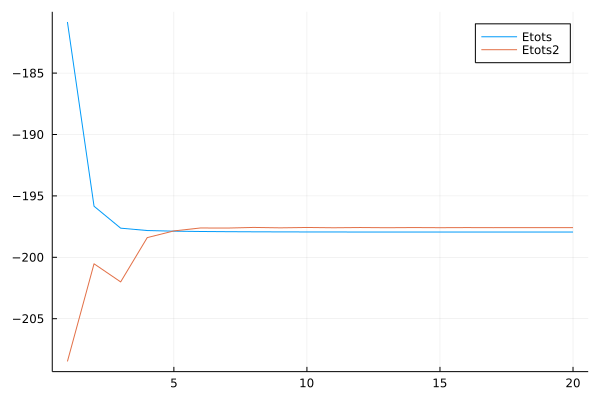

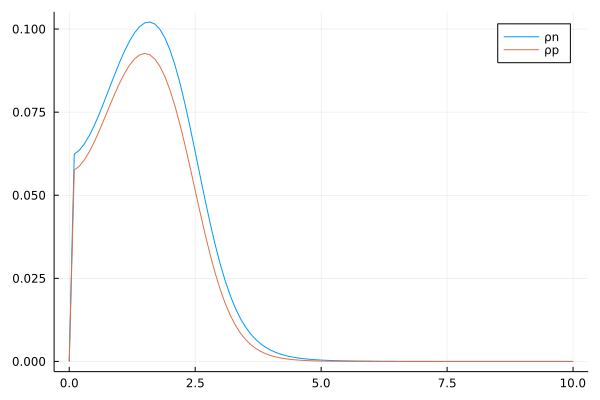

  0.424678 seconds (2.50 k allocations: 16.710 MiB)
E = -197.94524410050968
E₂ = -197.58330010766508

i = 1: 
spEs[i] = -38.66477867116415
qnums[i] = Main.My.QuantumNumbers
  l: Int64 0
  j: Int64 1
  q: Int64 2

occ[i] = 1.0

i = 2: 
spEs[i] = -35.578908908397985
qnums[i] = Main.My.QuantumNumbers
  l: Int64 0
  j: Int64 1
  q: Int64 1

occ[i] = 1.0

i = 3: 
spEs[i] = -24.43917460887857
qnums[i] = Main.My.QuantumNumbers
  l: Int64 1
  j: Int64 1
  q: Int64 2

occ[i] = 1.0

i = 4: 
spEs[i] = -21.018225963211208
qnums[i] = Main.My.QuantumNumbers
  l: Int64 1
  j: Int64 1
  q: Int64 1

occ[i] = 1.0

i = 5: 
spEs[i] = -8.029931397351492
qnums[i] = Main.My.QuantumNumbers
  l: Int64 2
  j: Int64 1
  q: Int64 2

occ[i] = 0.0

i = 6: 
spEs[i] = -4.794749642628631
qnums[i] = Main.My.QuantumNumbers
  l: Int64 2
  j: Int64 1
  q: Int64 1

occ[i] = 0.2

i = 7: 
spEs[i] = -4.309544529095315
qnums[i] = Main.My.QuantumNumbers
  l: Int64 0
  j: Int64 1
  q: Int64 2

occ[i] = 0.0

i = 8: 
spEs[i] = -2.

In [56]:
param = My.PhysicalParam(N=10,Z=8, Nr=100)
HF_calc(param; iter_max=20)